# Библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Подготовка данных

In [ ]:
df = pd.read_csv('traffic_features.csv')

In [4]:
data = df.values.astype(np.float32)

In [5]:
df

,length,src_ip1,src_ip2,src_ip3,src_ip4,src_ip5,src_ip6,src_ip7,src_ip8,src_is_ipv6,...,dst_ip5,dst_ip6,dst_ip7,dst_ip8,dst_is_ipv6,ttl,proto,sport,dport,flags
0,496,0.752941,0.658824,0.0,0.003922,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.007843,0.066667,0.585489,0.028992,0.0
1,440,0.994156,0.000000,0.0,0.000000,0.260472,0.191394,0.993042,0.627268,1.0,...,0.0,0.0,0.0,0.000183,1.0,0.003922,0.066667,0.816556,0.028992,0.0
2,449,0.994156,0.000000,0.0,0.000000,0.260472,0.191394,0.993042,0.627268,1.0,...,0.0,0.0,0.0,0.000183,1.0,0.003922,0.066667,0.816556,0.028992,0.0
3,512,0.994156,0.000000,0.0,0.000000,0.260472,0.191394,0.993042,0.627268,1.0,...,0.0,0.0,0.0,0.000183,1.0,0.003922,0.066667,0.816556,0.028992,0.0
4,508,0.994156,0.000000,0.0,0.000000,0.260472,0.191394,0.993042,0.627268,1.0,...,0.0,0.0,0.0,0.000183,1.0,0.003922,0.066667,0.816556,0.028992,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491097,218,0.752941,0.658824,0.0,0.780392,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.066667,0.868360,0.101732,0.0
491098,308,0.752941,0.658824,0.0,0.831373,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.066667,0.870359,0.101732,0.0
491099,514,0.752941,0.658824,0.0,0.156863,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.066667,0.081682,0.081682,0.0
491100,534,0.994156,0.000000,0.0,0.000000,0.759838,0.492180,0.994064,0.406012,1.0,...,0.0,0.0,0.0,0.003830,1.0,1.000000,0.066667,0.081682,0.081682,0.0


In [6]:
df.shape

(491102, 24)

Конфигурация

In [7]:
MODEL_PATH = 'anomaly_detector.pth'
SCALER_PATH = 'scaler.pkl'
BATCH_SIZE = 256
EPOCHS = 50
LR = 1e-3
INPUT_DIM = df.shape[1]

Разделение данных на обучающую и валидационную выборки

In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False, random_state=42)

In [9]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

joblib.dump(scaler, SCALER_PATH)

['scaler.pkl']

In [10]:
train_dataset = TensorDataset(torch.tensor(train_data))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(torch.tensor(val_data))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Обучение модели

In [11]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    early_stopping=None,
    epochs=50,
    model_path='best_model.pth'
):
    history = {'train': [], 'val': []}
    best_loss = float('inf')
    best_epoch = 0

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            inputs = batch[0].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_path)

        if early_stopping:
            if early_stopping(val_loss):
                print(f'Ранняя остановка на эпохе {epoch+1}')
                break

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        print('-'*50)

    model.load_state_dict(torch.load(model_path))
    print(f'Обучение завершено. Лучшая модель сохранена как {model_path}')

    return model, history, best_epoch

In [12]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(24, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 24)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AnomalyDetector().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
early_stopping = EarlyStopping(patience=7, delta=0.001)

In [15]:
trained_model, history, best_epoch = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    early_stopping=early_stopping,
    epochs=EPOCHS,
    model_path=MODEL_PATH
)

Epoch 1/50
Train Loss: 0.110956 | Val Loss: 0.054914
--------------------------------------------------
Epoch 2/50
Train Loss: 0.023601 | Val Loss: 0.023859
--------------------------------------------------
Epoch 3/50
Train Loss: 0.014310 | Val Loss: 0.016175
--------------------------------------------------
Epoch 4/50
Train Loss: 0.008638 | Val Loss: 0.010832
--------------------------------------------------
Epoch 5/50
Train Loss: 0.005346 | Val Loss: 0.007991
--------------------------------------------------
Epoch 6/50
Train Loss: 0.004194 | Val Loss: 0.006147
--------------------------------------------------
Epoch 7/50
Train Loss: 0.003516 | Val Loss: 0.005014
--------------------------------------------------
Epoch 8/50
Train Loss: 0.002533 | Val Loss: 0.003927
--------------------------------------------------
Epoch 9/50
Train Loss: 0.002277 | Val Loss: 0.003208
--------------------------------------------------
Epoch 10/50
Train Loss: 0.001789 | Val Loss: 0.002507
----------

График обучения

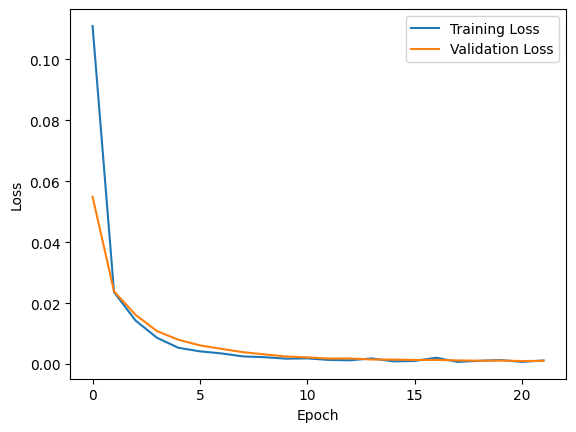

In [16]:
plt.plot(history['train'], label='Training Loss')
plt.plot(history['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Расчет порога аномальности

Для расчета порога аномальности был выбран **99-й** перцентиль ошибок

In [17]:
percentile = 0.99

In [18]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        loss = torch.mean((outputs - inputs)**2, dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())

threshold = np.quantile(reconstruction_errors, percentile)
print(f'Порог аномальности: {threshold:.4f}')

Порог аномальности: 0.0054


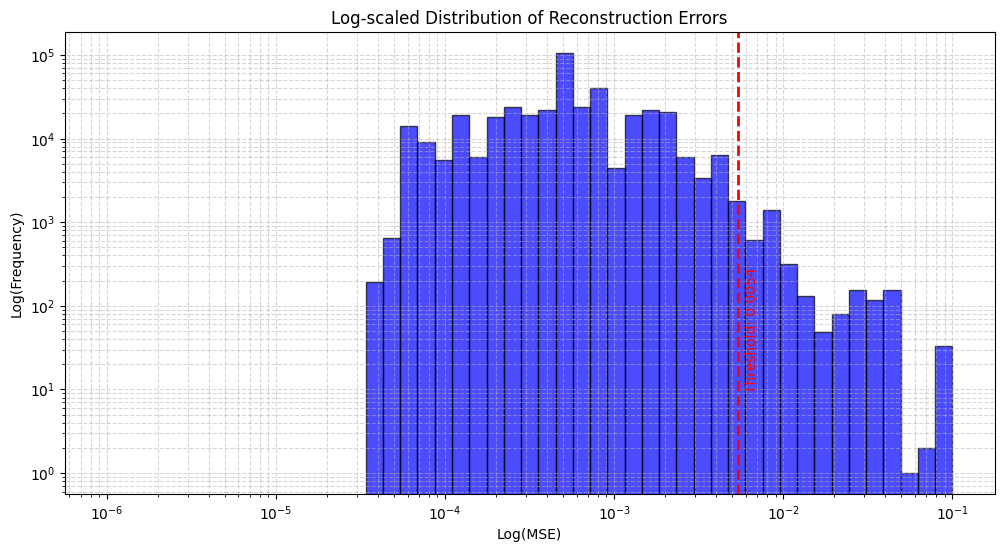

In [19]:
plt.figure(figsize=(12, 6))

plt.hist(reconstruction_errors,
         bins=np.logspace(np.log10(1e-6), np.log10(0.1), 50),
         alpha=0.7,
         color='blue',
         edgecolor='black')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.axvline(threshold, color='red', linestyle='--', linewidth=2)

plt.text(threshold*1.1, 10,
         f'Threshold: {threshold:.4f}',
         color='red',
         rotation=90)

plt.title('Log-scaled Distribution of Reconstruction Errors')
plt.xlabel('Log(MSE)')
plt.ylabel('Log(Frequency)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

# Аномалии

## Обнаружение аномалий

In [20]:
def detect_anomalies(data_loader, model, threshold):
    model.eval()
    anomalies = []
    anomaly_indices = []
    total_processed = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to(device).float()
            batch_size = inputs.size(0)

            outputs = model(inputs)
            loss = torch.mean((outputs - inputs)**2, dim=1)
            batch_anomalies = (loss > threshold).cpu().numpy()

            batch_anomaly_indices = np.where(batch_anomalies)[0]

            global_indices = batch_anomaly_indices + total_processed
            anomaly_indices.extend(global_indices.tolist())

            total_processed += batch_size

            anomalies.extend(batch_anomalies)

    return anomalies, anomaly_indices

In [21]:
anomalies, anomaly_indices = detect_anomalies(val_loader, model, threshold)

anomalous_data = df.iloc[anomaly_indices]
print(f'Обнаружено аномалий: {sum(anomalies)}')
anomalous_data.transpose()

Обнаружено аномалий: 1914


,346,513,519,527,533,663,682,1479,1494,1563,...,97610,97716,97717,97723,97725,97726,97727,97728,97734,97952
length,54.000000,1514.000000,1514.000000,54.000000,1514.000000,1514.000000,1514.000000,1514.000000,54.000000,1514.000000,...,7290.000000,66.000000,1514.000000,1514.000000,1514.000000,66.000000,66.000000,1514.000000,1514.000000,1514.000000
src_ip1,0.172549,0.752941,0.752941,0.172549,0.752941,0.752941,0.752941,0.752941,0.172549,0.752941,...,0.572549,0.752941,0.572549,0.572549,0.572549,0.752941,0.752941,0.572549,0.572549,0.572549
src_ip2,0.827451,0.658824,0.658824,0.827451,0.658824,0.658824,0.658824,0.658824,0.827451,0.658824,...,0.294118,0.658824,0.294118,0.294118,0.294118,0.658824,0.658824,0.294118,0.294118,0.294118
src_ip3,0.062745,0.000000,0.000000,0.062745,0.000000,0.000000,0.000000,0.000000,0.062745,0.000000,...,0.478431,0.000000,0.478431,0.478431,0.478431,0.000000,0.000000,0.478431,0.478431,0.478431
src_ip4,0.988235,0.223529,0.223529,0.988235,0.223529,0.223529,0.223529,0.223529,0.988235,0.223529,...,0.674510,0.223529,0.674510,0.674510,0.674510,0.223529,0.223529,0.674510,0.674510,0.674510
src_ip5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
src_ip6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
src_ip7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
src_ip8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
src_is_ipv6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Classification Report

In [22]:
anomalies = [
    # DDoS-атака (высокий объем трафика с одного IP)
    {
        'length': 0.95,          # Очень длинный пакет (максимальное значение ~1500 байт)
        'src_ip1': 0.752941,     # IPv4-адрес источника (нормальный)
        'src_ip2': 0.658824,
        'src_ip3': 0.0,
        'src_ip4': 0.003922,
        'src_ip5': 0.0,
        'src_ip6': 0.0,
        'src_ip7': 0.0,
        'src_ip8': 0.0,
        'src_is_ipv6': 0.0,
        'dst_ip1': 0.996078,     # Неизвестный IPv4-адрес назначения
        'dst_ip2': 0.0,
        'dst_ip3': 0.0,
        'dst_ip4': 0.0,
        'dst_ip5': 0.0,
        'dst_ip6': 0.0,
        'dst_ip7': 0.0,
        'dst_ip8': 0.0,
        'dst_is_ipv6': 0.0,      # IPv4
        'ttl': 0.015686,         # Низкий TTL (подозрительный)
        'proto': 0.066667,       # UDP (нормально, но в сочетании с другими признаками)
        'sport': 0.123456,       # Нестандартный порт источника
        'dport': 0.028992,       # Порт 1900 (SSDP, часто используется в DDoS)
        'flags': 0.5             # Нестандартные флаги (аномалия)
    },

    # Сканирование портов (множество запросов на разные порты)
    {
        'length': 0.6,
        'src_ip1': 0.994156,
        'src_ip2': 0.0,
        'src_ip3': 0.0,
        'src_ip4': 0.0,
        'src_ip5': 0.260472,
        'src_ip6': 0.191394,
        'src_ip7': 0.993042,
        'src_ip8': 0.627268,
        'src_is_ipv6': 1.0,
        'dst_ip1': 0.752941,
        'dst_ip2': 0.658824,
        'dst_ip3': 0.0,
        'dst_ip4': 0.003922,
        'dst_ip5': 0.0,
        'dst_ip6': 0.0,
        'dst_ip7': 0.0,
        'dst_ip8': 0.0,
        'dst_is_ipv6': 0.0,
        'ttl': 1.0,              # Максимальный TTL (подозрительно)
        'proto': 0.066667,       # UDP
        'sport': 0.543210,       # Случайный порт источника
        'dport': 0.999999,       # Экзотический порт назначения (65535)
        'flags': 0.0
    },

    # DNS-туннелирование (подозрительная активность через DNS)
    {
        'length': 0.8,            # Под конец временного интервала
        'src_ip1': 0.994156,     # IPv6-адрес источника
        'src_ip2': 0.0,
        'src_ip3': 0.0,
        'src_ip4': 0.0,
        'src_ip5': 0.123456,
        'src_ip6': 0.456789,
        'src_ip7': 0.0,
        'src_ip8': 0.0,
        'src_is_ipv6': 1.0,
        'dst_ip1': 0.0,          # DNS-сервер (порт 53)
        'dst_ip2': 0.0,
        'dst_ip3': 0.0,
        'dst_ip4': 0.0,
        'dst_ip5': 0.000123,
        'dst_ip6': 0.0,
        'dst_ip7': 0.0,
        'dst_ip8': 0.0,
        'dst_is_ipv6': 1.0,      # IPv6
        'ttl': 0.5,
        'proto': 0.035294,       # TCP (порт 53 нестандартен для TCP)
        'sport': 0.123456,
        'dport': 0.000808,       # 53 / 65535 ≈ 0.000808
        'flags': 0.2             # Необычные флаги
    },

    # Подозрительный IPv6-трафик (редкие IPv6-адреса)
    {
        'length': 0.7,
        'src_ip1': 0.996078,     # Неизвестный IPv6-адрес
        'src_ip2': 0.123456,
        'src_ip3': 0.654321,
        'src_ip4': 0.987654,
        'src_ip5': 0.111222,
        'src_ip6': 0.333444,
        'src_ip7': 0.0,
        'src_ip8': 0.0,
        'src_is_ipv6': 1.0,
        'dst_ip1': 0.0,          # Локальный IPv6-адрес
        'dst_ip2': 0.0,
        'dst_ip3': 0.0,
        'dst_ip4': 0.0,
        'dst_ip5': 0.0,
        'dst_ip6': 0.0,
        'dst_ip7': 0.0,
        'dst_ip8': 0.0,
        'dst_is_ipv6': 1.0,
        'ttl': 0.007843,         # Очень низкий TTL
        'proto': 0.105882,       # ICMPv6 (редкий протокол)
        'sport': 0.0,
        'dport': 0.0,
        'flags': 0.9             # Агрессивные флаги
    }
]

In [23]:
anomalies_df = pd.DataFrame(anomalies)

In [24]:
anomalies_upsampled = anomalies_df.sample(n=100, replace=True, random_state=42)

In [25]:
anomalies_array = anomalies_upsampled.values.astype(np.float32)

In [26]:
val_data_with_anomalies = np.concatenate((val_data, anomalies_array))

In [27]:
val_labels_with_anomalies = np.concatenate([
    np.zeros(len(val_data)),
    np.ones(len(anomalies_array))
])

In [28]:
loaded_scaler = joblib.load(SCALER_PATH)

val_data_with_anomalies = loaded_scaler.transform(val_data_with_anomalies)

In [29]:
val_dataset_with_anomalies = TensorDataset(torch.tensor(val_data_with_anomalies))
val_loader_with_anomalies = DataLoader(val_dataset_with_anomalies, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
anomalies_detected, anomaly_indices_detected = detect_anomalies(val_loader_with_anomalies, model, threshold)

In [31]:
y_pred = np.zeros(len(val_data_with_anomalies))  # Все предсказания = 0 (норма)
y_pred[anomaly_indices_detected] = 1  # Помечаем аномалии как 1

In [32]:
print(classification_report(val_labels_with_anomalies, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     98221
         1.0       0.00      1.00      0.00       100

    accuracy                           0.00     98321
   macro avg       0.00      0.50      0.00     98321
weighted avg       0.00      0.00      0.00     98321

